# TensorFlow Keras API

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
# from plotnine import *

# Quick hack to make tb highlighting configurable - https://github.com/ipython/ipython/pull/13756
# from IPython.core.ultratb import VerboseTB
# VerboseTB._tb_highlight = "bg:#039dfc"

try:
    plt.style.use("my_dracula")
except:
    plt.style.use("default")
matplotlib.rcParams['figure.figsize'] = [9, 3]

print("TensorFlow Version " + tf.__version__)
print(str(tf.config.list_physical_devices()))

TensorFlow Version 2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Improved implementation to understand and play around with the *Keras API* and *tf.data.Dataset* format for training.

When using Keras it's basically the same, just do these minor changes:
- swap the base class *"tf.Module"* with *"tf.keras.layers.Layer"*
- change *"\_\_call\_\_"* to *"call"* (there is no change in how it is used)
- have an extra step: *"build(self, input_shape)"* which is called only once, on the first call, with the input shape (usually used to initialize weights)
- should add *"training"* argument to *"call"*

Keras layers also have additional features for losses, metrics, etc.


Models in Keras can be defined as nested layers or with the class *"tf.keras.Model"*, which inherits from *"tf.keras.layers.Layer"* and has some extra functionalities specific for models. Its basic syntax is the same.


---
**Note from guide**


For historical compatibility reasons Keras layers do not collect variables from modules, so your models should **<u>use only modules or only Keras layers</u>**. However, the methods shown are the same in either case.

---

## Functions

### Class declarations for NN

In [2]:
# dense layer with flexible input shape and activation function passed
class Dense_flex(tf.keras.layers.Layer):
    def __init__(self, out_features, activation=None, name=None):
        super().__init__(name=name)

        self.activation = activation
        self.out_features = out_features

    def build(self, input_shape):
        if self.activation is None:
            initializer = "norm_Xavier"
        else:
            if self.activation._tf_api_names_v1[0] == "nn.relu":
                initializer = "He"
            else:
                initializer = "norm_Xavier"

        input_features = input_shape[-1]

        if initializer == "He":
            # parameter initialization with He initialization for ReLu
            self.w = tf.Variable(tf.random.normal([input_features, self.out_features],
                                                  stddev=np.sqrt(2/input_features)), name="w")
            self.b = tf.Variable(tf.random.normal([self.out_features], stddev=np.sqrt(2/input_features)), name="b")
        elif initializer == "norm_Xavier":
            # initialize weights with normalized Xavier
            xavier = np.sqrt(6)/np.sqrt(input_features + self.out_features)
            self.w = tf.Variable(tf.random.uniform([input_features, self.out_features],
                                                   minval=-xavier, maxval=xavier), name="w")
            self.b = tf.Variable(tf.random.uniform([self.out_features], minval=-xavier, maxval=xavier), name="b")
        else:
            # should not be possible to get here
            print("ERROR INITIALIZER")

    def call(self, x, training=False):
        z = tf.matmul(x, self.w) + self.b
        if self.activation is not None:
            return self.activation(z)
        else:
            return z

In [3]:
# used for shallow network with no hidden layers - only output layer
# used for my auto-bulid of DNN
class Identity_layer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)

    def call(self, x, training=False):
        return x

In [4]:
# MLP classifier
# hidden_layer: list of neuron per layer e.g. [10, 5]
# activation: activation function for hidden layers
class Classifier_NN(tf.keras.Model):
    def __init__(self, hidden_layers, classes=2, input_shape=None, activation=tf.nn.relu, name=None):
        super().__init__(name=name)

        if classes == 1:
            print("classes set to 2, i.e. one output feature")
            classes = 2
        if classes == 2:
            self.out_features = 1
            self.output_activation = tf.nn.sigmoid
        else:
            self.out_features = classes
            self.output_activation = tf.nn.softmax

        self.layer = []
        # hidden layers
        for _, neurons in enumerate(hidden_layers):
            if neurons > 0:
                self.layer.append(Dense_flex(neurons, activation))
            else:
                self.layer.append(Identity_layer())
        # output layer - linear output, i.e. logits
        self.layer.append(Dense_flex(self.out_features, activation=None))

        # build model on initialization if input_shape was passed
        if input_shape is not None:
            self.build(input_shape)

    def call(self, x, training=False):
        # if tf.rank(x) < 2:
        #     x = tf.reshape(x, [-1, 1])
        for i, _ in enumerate(self.layer):
            x = self.layer[i](x)

        if training:
            return x
        else:
            return self.output_activation(x)

### Training functions

In [5]:
# training function using tf.data stucture
# args used to pass n_classes to cross entropy loss for classification
@tf.function
def train(model, data, y, loss, learning_rate):

    with tf.GradientTape() as t:
        current_loss = loss(y, model(data, training=True))

    grad = t.gradient(current_loss, model.variables)

    for g, var in zip(grad, model.variables):
        var.assign_sub(learning_rate * g)

In [6]:
# training loop
# args used to pass n_classes to cross entropy loss for classification
def training_loop(model, dataset, loss, learning_rate=0.01, epochs=10):

    hist_loss = []
    # hist_loss.append(loss(y, model(x)).numpy())

    for epoch in range(epochs):
        # if not epoch % 10:
        #     print(f"Starting {epoch = }")

        # iterate over batches
        epoch_loss = 0
        for step, (x_batch, y_batch) in enumerate(dataset):
            train(model, x_batch, y_batch, loss, learning_rate)
            current_batch_loss = loss(y_batch, model(x_batch, training=True)).numpy()
            epoch_loss += loss(y_batch, model(x_batch, training=True)).numpy()

        hist_loss.append(epoch_loss)

    plt.plot(range(epochs), hist_loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training")
    # plt.show()

In [7]:
def cross_entropy_logits(y, logits):
    if logits.shape[-1] == 1:  # case for binary classifier
        y = tf.reshape(y, [-1, 1])
        y = tf.cast(y, tf.float32)
        probs = tf.nn.sigmoid(logits)
        # y_pred = tf.reshape(y_pred, y.shape.as_list())
        return - tf.reduce_mean(y * tf.math.log(probs) + (1. - y) * tf.math.log(1. - probs))
    else:  # multiclass case
        y = tf.cast(y, tf.int8)
        y = tf.one_hot(y, logits.shape[-1], axis=-1)
        probs = tf.nn.softmax(logits)
        return - tf.reduce_mean(y * tf.math.log(probs))

In [8]:
def accuracy(y_true, y_pred):
    pred = np.argmax(y_pred, axis=1)
    right = np.where(pred == y_true, 1, 0)

    return np.sum(right)/right.shape[0]

In [9]:
def loss_batched_dataset(model, loss, dataset):
    pred = []
    y_true = []
    for step, (x_batch, y_batch) in enumerate(dataset):
        pred.append(model(x_batch))
        y_true.append(y_batch)
    return loss(tf.concat(y_true, axis=0), tf.concat(pred, axis=0))

## Examples classification

### Linear binary

In [10]:
def f(x):
    a = 1.
    b = 0.
    return x * a - b


def plot_2d_classes(data, labels):
    if tf.rank(labels) > 1:
        labels = tf.reshape(labels, [-1])
    p = "PRGn"
    x1 = data.columns[0]
    x2 = data.columns[1]
    sns.scatterplot(data, x=x1, y=x2, hue=labels, s=10, palette=p, legend=False, hue_norm=(0, 1))
    plt.gcf().colorbar(plt.cm.ScalarMappable(cmap=p), location="bottom", ticks=[0, 1], ax=plt.gca(),
                       pad=0.18, extend="neither", label="label", shrink=0.8)
    plt.gca().set_box_aspect(1)

In [11]:
N = 1000
dim = 2

data = pd.DataFrame(np.random.uniform(0., 10, [N, dim]).astype(np.float32), columns=["x1", "x2"])
labels = np.where(f(data.x1) <= data.x2, 1, 0)

dataset = tf.data.Dataset.from_tensor_slices((data, labels)).batch(int(N/10))

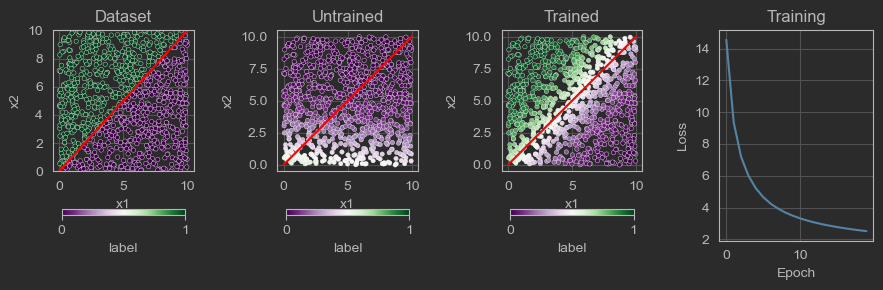

In [12]:
n_classes = 2
model = Classifier_NN([0], n_classes)
model.build(tf.keras.Input(shape=data.shape[-1]).shape)

lin_space = np.linspace(0., 10.)

plt.subplot(141)
plt.plot(lin_space, f(lin_space), color="red")
plt.ylim(0, 10)
plot_2d_classes(data, labels)
plt.title("Dataset")

plt.subplot(142)
pred = model(data)
plot_2d_classes(data, pred)
plt.title("Untrained")
plt.plot(lin_space, f(lin_space), color="red")

plt.subplot(144)
training_loop(model, dataset, cross_entropy_logits, 1e-2, 20)
plt.title("Training")

plt.subplot(143)
pred_trained = model(data)
plot_2d_classes(data, pred_trained)
plt.title("Trained")
plt.plot(lin_space, f(lin_space), color="red")

plt.tight_layout()

plt.show()

### Non-linear binary

In [13]:
N = 1000
dim = 2
R = 1.
data = pd.DataFrame(np.random.uniform(-R, R, [N, dim]).astype(np.float32), columns=["x1", "x2"])
labels = np.where(data.x1**2 + data.x2**2 <= (R/1.3)**2, 1, 0)

dataset = tf.data.Dataset.from_tensor_slices((data, labels)).batch(int(N/2))

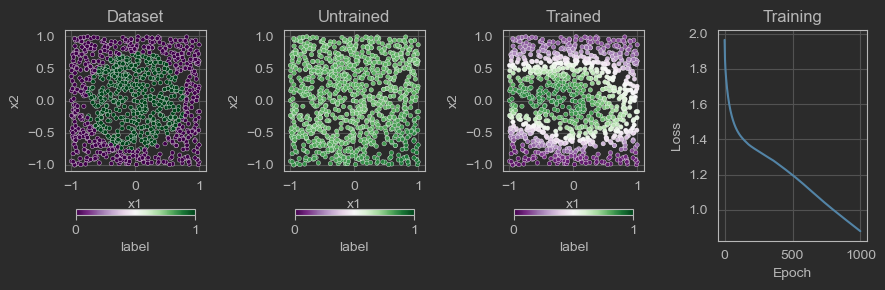

In [14]:
n_classes = 2
model = Classifier_NN([10, 10, 10, 10, 10], n_classes)
model.build(tf.keras.Input(shape=data.shape[-1]).shape)

plt.subplot(141)
plot_2d_classes(data, labels)
plt.title("Dataset")

plt.subplot(142)
pred = model(data)
plot_2d_classes(data, pred)
plt.title("Untrained")

plt.subplot(144)
plt.title("Training")
training_loop(model, dataset, cross_entropy_logits, 5e-3, 1000)

plt.subplot(143)
plt.title("Trained")
pred_trained = model(data)
plot_2d_classes(data, pred_trained)

plt.tight_layout()
plt.show()

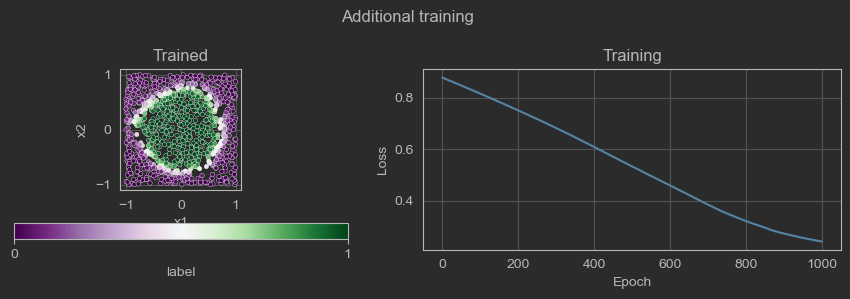

In [15]:
plt.suptitle("Additional training")
plt.subplot(122)
plt.title("Training")
training_loop(model, dataset, cross_entropy_logits, 5e-3, 1000)

plt.subplot(121)
plt.title("Trained")
pred_trained = model(data)
plot_2d_classes(data, pred_trained)

plt.tight_layout()
plt.show()

### Linear multi-class

In [16]:
def plot_2d_multi_class(data, pred):
    if tf.rank(pred) == 1:
        labels = pred
        labels_p = np.ones(pred.shape)
    else:
        labels = np.argmax(pred, axis=1)
        labels_p = np.max(pred, axis=1)

    #p = "PRGn"
    x1 = data.columns[0]
    x2 = data.columns[1]
    sns.scatterplot(data, x=x1, y=x2, hue=labels, s=10, alpha=labels_p) # , palette=p, legend=False, hue_norm=(0, 1))
    # plt.gcf().colorbar(plt.cm.ScalarMappable(cmap=p), location="bottom", ticks=[0, 1], ax=plt.gca(),
    #                    pad=0.18, extend="neither", label="label", shrink=0.8)
    plt.gca().set_box_aspect(1)

In [17]:
N = 1000
dim = 2
R = 1.
data = pd.DataFrame(np.random.uniform(-R, R, [N, dim]).astype(np.float32), columns=["x1", "x2"])
data = data.assign(labels=lambda x: np.where((x.x1 < x.x2) & (-x.x1 < x.x2), 1, 0))
data = data.assign(labels=lambda x: np.where((x.x1 < x.x2) & (-x.x1 > x.x2), 2, x.labels))
data = data.assign(labels=lambda x: np.where((x.x1 > x.x2) & (-x.x1 > x.x2), 3, x.labels))
labels = data.pop("labels").astype("int")

dataset = tf.data.Dataset.from_tensor_slices((data, labels)).batch(int(N/2))

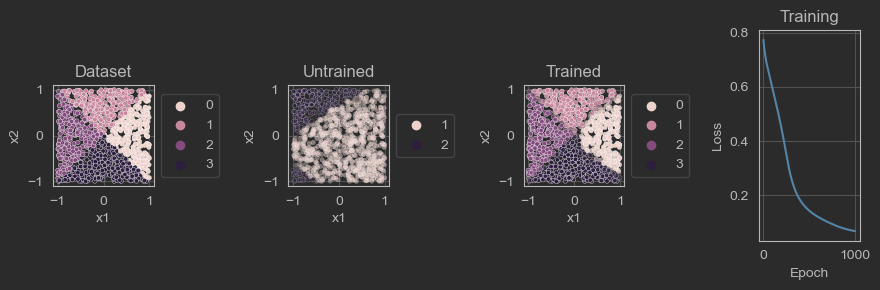

In [18]:
n_classes = 4
model = Classifier_NN([4, 4], n_classes)
model.build(tf.keras.Input(shape=data.shape[-1]).shape)

plt.subplot(141)
plot_2d_multi_class(data, labels)
plt.title("Dataset")
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(142)
pred = model(data)
plot_2d_multi_class(data, pred)
plt.title("Untrained")
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(144)
plt.title("Training")
training_loop(model, dataset, cross_entropy_logits, 1e-1, 1000)

plt.subplot(143)
plt.title("Trained")
pred_trained = model(data)
plot_2d_multi_class(data, pred_trained)
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Iris dataset

In [19]:
(data_train, data_test), info = tfds.load("iris", split=["train[:75%]", "train[75%:]"], as_supervised=True, with_info=True)
data_train = data_train.shuffle(buffer_size=150).batch(150)
data_test = data_test.batch(50)
info

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='C:\\Users\\Leonardo\\tensorflow_datasets\\iris\\2.0.0',
    file_format=tfrecord,
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        '

### My NN with keras training on Iris

In [20]:
model = Classifier_NN([10, 10, 10], 3)
# not needed since fitting via keras implementation
# model.build(tf.keras.Input(shape=info.features["features"].shape).shape)


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    data_train,
    epochs=100,
    validation_data=data_test,
    verbose=0,
)

model.evaluate(data_test)

C:\Users\Leonardo\.conda\envs\tf_env\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 17ms/step - loss: 0.9081 - sparse_categorical_accuracy: 0.3421


[0.908066987991333, 0.34210526943206787]

## Keras annotations

Pre-training accuracy: 0.342
After-training accuracy: 0.895


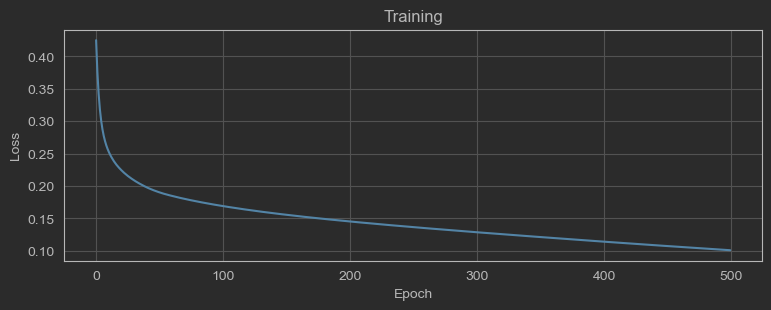

In [21]:
model = Classifier_NN([10, 10, 10], 3)
model.build(tf.keras.Input(shape=info.features["features"].shape).shape)

print(f"Pre-training accuracy: {loss_batched_dataset(model, accuracy, data_test):.3f}")
training_loop(model, data_train, cross_entropy_logits, 1e-2, 500)
print(f"After-training accuracy: {loss_batched_dataset(model, accuracy, data_test):.3f}")

Proper *"Model.summary()"* works only through the *Sequential* and *Functional* APIs.


When subclassing *"tf.keras.Model"* keep in mind that the summary will not be able to show the layer's output shapes and *"tf.keras.utils.plot_model(Model, show_shapes=True)"* will not print the model.

If in need of those, try to re-define the model through the Functional API - like done below, or could try to add/re-define the summary (and maybe build) functions in the subclassed model.

In [37]:
t = Classifier_NN([10,5], 3)
t.build((None, 5))
t.summary()

Model: "classifier_nn_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flex_28 (Dense_flex)  multiple                  60        
                                                                 
 dense_flex_29 (Dense_flex)  multiple                  55        
                                                                 
 dense_flex_30 (Dense_flex)  multiple                  18        
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


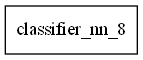

In [38]:
tf.keras.utils.plot_model(t, show_shapes=True)

In [39]:
def convert_model_to_functional(model, input_shape=None, name=None):
    if input_shape is None:
        input_shape = model.input_shape

    inputs = tf.keras.Input(shape=input_shape)
    outputs = model.call(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


def model_summary(model, input_shape=None, name=None):
    m = convert_model_to_functional(model, input_shape, name)
    m.summary()


def plot_model(model, input_shape=None, name=None, show_shapes=True, file_to_save=None):
    m = convert_model_to_functional(model, input_shape, name)
    if file_to_save is not None:
        return tf.keras.utils.plot_model(m, file_to_save, show_shapes=show_shapes)
    else:
        return tf.keras.utils.plot_model(m, show_shapes=show_shapes)

In [42]:
t = Classifier_NN([10, 10, 10], 3)
model_summary(t, input_shape=(4,))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_flex_35 (Dense_flex)  (None, 10)                50        
                                                                 
 dense_flex_36 (Dense_flex)  (None, 10)                110       
                                                                 
 dense_flex_37 (Dense_flex)  (None, 10)                110       
                                                                 
 dense_flex_38 (Dense_flex)  (None, 3)                 33        
                                                                 
 tf.nn.softmax_2 (TFOpLambda  (None, 3)                0         
 )                                                               
                                                           

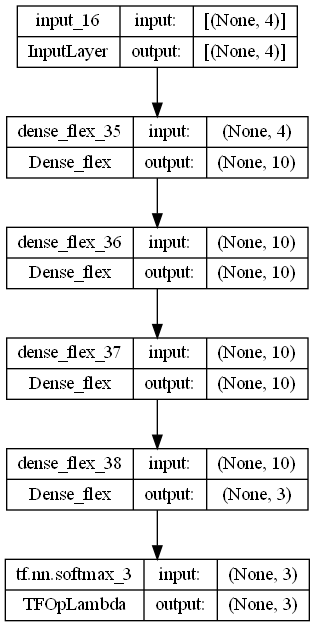

In [43]:
plot_model(t, input_shape=(4,))